In [54]:
import setigen as stg
import bifrost as bf
from bifrost.fdmt import Fdmt
import numpy as np
import blimpy as bl
import matplotlib.pyplot as plt
from astropy import units as u

fdmt= Fdmt()

In [2]:
%matplotlib inline

In [55]:
def ddframe(stgframe, max_drift_rate, negative_delays, exponent):
    
    fr=stgframe
    max_delay = max_drift_rate
    gulp_size = 4 * 8192

    d_cpu = np.expand_dims(fr.data, axis=0) + 0.1
    print(d_cpu.shape)

    ## Initialize FDMT
    n_disp = max_delay
    n_time = d_cpu.shape[2]
    n_chan = d_cpu.shape[1]
    fdmt.init(n_chan, n_disp, fr.fch1, fr.df, space="cuda", exponent=exponent)


    # Input shape is (1, n_freq, n_time)
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')

    # Execute FDMT
    fdmt.execute(d_in, d_out, negative_delays=negative_delays)

    d_out = d_out.copy(space='system')
    
    #plotting the fdmt
    plt.figure(figsize=(9, 6))
    plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto')
    
    plt.xlabel("Time")
    plt.ylabel("Dispersion trial")
    plt.colorbar()
    

In [56]:
#define a sample setigen frame
drift_factor = 4
fr = stg.Frame(shape=(16, 128))
drift_rate = drift_factor * fr.unit_drift_rate
fr.add_signal(stg.constant_path(f_start=fr.get_frequency(16),
                                drift_rate=drift_rate),
              stg.constant_t_profile(level=1),
              stg.box_f_profile(width=fr.df),
              doppler_smearing=True,
              smearing_subsamples=drift_factor)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(1, 16, 128)


/tmp/ipykernel_28580/3700221358.py:28: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto')


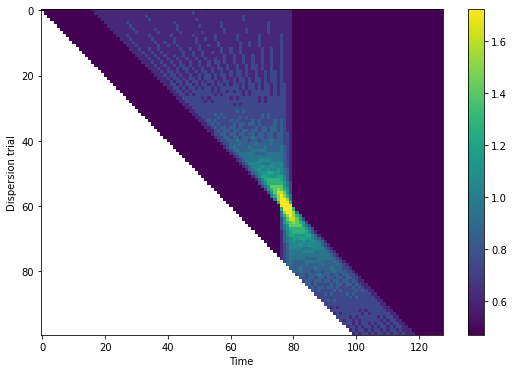

In [61]:
ddframe(fr, 100, True, 1)

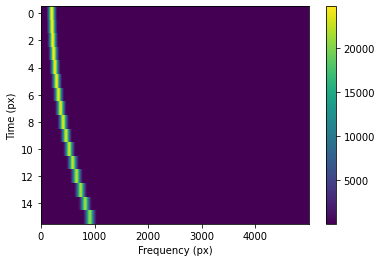

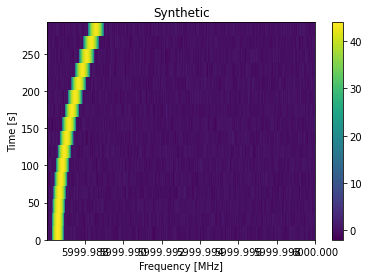

In [51]:
#quadratic signal
fr = stg.Frame(shape=(16, 5000))
fr.add_noise(1)
fr.add_signal(stg.squared_path(f_start=fr.get_frequency(200),
                               drift_rate=0.05*u.Hz/u.s),
              stg.constant_t_profile(level=fr.get_intensity(snr=1e6)),
              stg.sinc2_f_profile(width=fr.df*100),
              doppler_smearing=True,
              smearing_subsamples=10)

fr.plot()
plt.show()

fr.bl_plot()
plt.show()

(1, 16, 5000)


/tmp/ipykernel_28580/3700221358.py:28: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto')


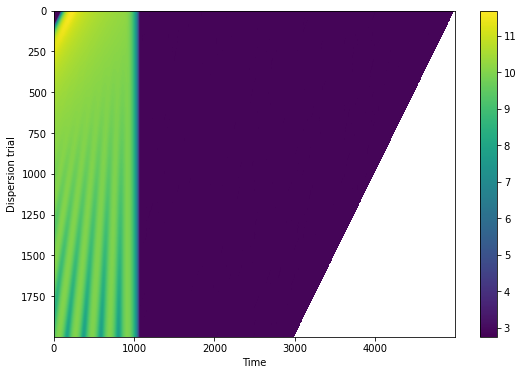

In [52]:
ddframe(fr,2000,False,2)

(1, 16, 5000)


/tmp/ipykernel_28580/3700221358.py:28: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto')


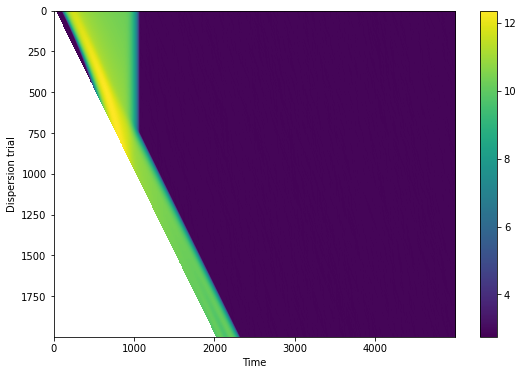

In [53]:
ddframe(fr,2000,True,2)

In [50]:
fp = 'guppi_59334_59899_6179049297_ProxCen_S_0001.0002.fil'
fil = bl.Waterfall(fp)
fr=fil.data[:, 0:1, :]